The objective of this notebook is to visualize the overheads in the data std::vector branches in ROOT files

In [1]:
import io
import uproot
import math
import numpy as np
import requests
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
url = "https://github.com/CoffeaTeam/coffea/blob/6d548538653e7003281a572f8eec5d68ca57b19f/tests/samples/DAOD_PHYSLITE_21.2.108.0.art.pool.root?raw=true"

In [3]:
bin_data = requests.get(url).content

In [4]:
f = uproot.open(io.BytesIO(bin_data))

# `std::vector<float>`

Let's start with a single-jagged vector branch:

In [5]:
vbranch = f["CollectionTree"]["AnalysisElectronsAuxDyn.pt"]

In [6]:
vbranch.typename

'std::vector<float>'

In [7]:
basket = vbranch.basket(0)

Uproot can give us the uncompressed data (bytes) of baskets:


In [8]:
len(basket.data), basket.data.dtype

(452, dtype('uint8'))

This does not include the event offsets which are stored in the end of the basket data. The start of this is given by `basket.border` in uproot:

In [9]:
len(basket.raw_data)

620

In [10]:
(basket.raw_data[:basket.border] == basket.data).all()

True

You can quickly see the stuff after "border" encodes the offsets (note: big-endian storage in ROOT, therefore the `>`). There seems to be a shift between the raw values from ROOT and what uproot reports, maybe the ROOT ones start counting from the TBasket header, so we have to subtract `fKeylen`

In [11]:
basket.raw_data[basket.border:].view(">i4")

array([ 41, 103, 113, 123, 137, 151, 161, 171, 181, 191, 205, 219, 229,
       239, 249, 259, 273, 283, 297, 311, 321, 331, 341, 351, 365, 375,
       389, 399, 413, 423, 433, 443, 453, 463, 473, 483, 493, 507, 517,
       527, 541,   0], dtype=int32)

In [12]:
basket.byte_offsets

array([  0,  10,  20,  34,  48,  58,  68,  78,  88, 102, 116, 126, 136,
       146, 156, 170, 180, 194, 208, 218, 228, 238, 248, 262, 272, 286,
       296, 310, 320, 330, 340, 350, 360, 370, 380, 390, 404, 414, 424,
       438, 452], dtype=int32)

In [13]:
basket.raw_data[basket.border:].view(">i4")[1:] - basket.member("fKeylen")

array([   0,   10,   20,   34,   48,   58,   68,   78,   88,  102,  116,
        126,  136,  146,  156,  170,  180,  194,  208,  218,  228,  238,
        248,  262,  272,  286,  296,  310,  320,  330,  340,  350,  360,
        370,  380,  390,  404,  414,  424,  438, -103], dtype=int32)

the last offset is then equivalent to the border, also see

https://github.com/scikit-hep/uproot4/blob/76ca347ed8a423424e13f6b84066ec9dd8829ae9/src/uproot/models/TBasket.py#L304-L313

In [14]:
basket.border

452

`std::vector` seems to have a 10 byte header in ROOT files, so we can get the flat array by just skipping over these. They should be at the offsets in single-jagged vector branches:

In [15]:
basket.byte_offsets // 4

array([  0,   2,   5,   8,  12,  14,  17,  19,  22,  25,  29,  31,  34,
        36,  39,  42,  45,  48,  52,  54,  57,  59,  62,  65,  68,  71,
        74,  77,  80,  82,  85,  87,  90,  92,  95,  97, 101, 103, 106,
       109, 113], dtype=int32)

In [16]:
mask = np.ones_like(basket.data, dtype=bool)
mask[
    (basket.byte_offsets[:-1] + np.arange(10).reshape(-1, 1)).ravel()
] = False
flat_data = basket.data[mask].view(">f4")
flat_data

array([ 94581.61  ,  30130.377 ,  58636.33  ,  49505.742 ,   4684.2603,
        25817.498 ,   5629.012 ,  46239.547 ,  44434.38  ,  68449.836 ,
       101088.266 ,  38074.375 ,  67039.12  ], dtype=float32)

In [17]:
(basket.byte_offsets - 10) // 4

array([ -3,   0,   2,   6,   9,  12,  14,  17,  19,  23,  26,  29,  31,
        34,  36,  40,  42,  46,  49,  52,  54,  57,  59,  63,  65,  69,
        71,  75,  77,  80,  82,  85,  87,  90,  92,  95,  98, 101, 103,
       107, 110], dtype=int32)

In [18]:
flat_data

array([ 94581.61  ,  30130.377 ,  58636.33  ,  49505.742 ,   4684.2603,
        25817.498 ,   5629.012 ,  46239.547 ,  44434.38  ,  68449.836 ,
       101088.266 ,  38074.375 ,  67039.12  ], dtype=float32)

In [19]:
ak.unflatten([1, 2, 3, 4], [2, 2])

<Array [[1, 2], [3, 4]] type='2 * var * int64'>

In [20]:
flat_data.astype(np.float32).dtype

dtype('float32')

In [21]:
counts = (np.diff(basket.byte_offsets) - 10) // 4 # 4 because we have 32bit floats
ak.unflatten(flat_data.astype(np.float32), counts)

<Array [[], [], ... 3.81e+04], [6.7e+04]] type='40 * var * float32'>

and that's also what uproot gives us

In [22]:
vbranch.array()

<Array [[], [], ... 3.81e+04], [6.7e+04]] type='40 * var * float32'>

Now let's visualize for the current branch which bytes in a basket do what:

In [23]:
def marked_data_vector_4bytes(basket):
    # mask for the vector headers
    mask = np.ones_like(basket.data, dtype=bool)
    mask[
        (basket.byte_offsets[:-1] + np.arange(10).reshape(-1, 1)).ravel()
    ] = False
    
    # first mark everything in red colors based on the binary value
    data_1d = np.array(basket.raw_data)
    data = plt.cm.ScalarMappable(cmap=plt.cm.Reds).to_rgba(data_1d)
    # then mark everything that's not a vector header in green colors
    data[:basket.border][mask] = plt.cm.ScalarMappable(cmap=plt.cm.Greens).to_rgba(
        data_1d[:basket.border][mask]
    )
    # and finally everything after the border in blue
    data[basket.border:] = plt.cm.ScalarMappable(cmap=plt.cm.Blues).to_rgba(
        data_1d[basket.border:]
    )
    return data

In [24]:
data = marked_data_vector_4bytes(basket)

In [25]:
def plot_marked_data(data, nrows, ax=None):
    ax = ax or plt.gca()

    # reshape into 2D
    ncols = math.ceil(len(data) / nrows)
    n = nrows * ncols
    data = np.concatenate([data, np.zeros((n - len(data), 4))]) # pad
    data = data.reshape(nrows, ncols, 4)
    ax.imshow(data)
    ax.set_axis_off()
    
    # legend
    args = ([0, 0], 0, 0)
    handles = [
        Rectangle([0, 0], 0, 0, color="red", label="Vector header"),
        Rectangle(*args, color="green", label="Data"),
        Rectangle([0, 0], 0, 0, color="blue", label="Offsets"),
    ]
    ax.legend(handles=handles)

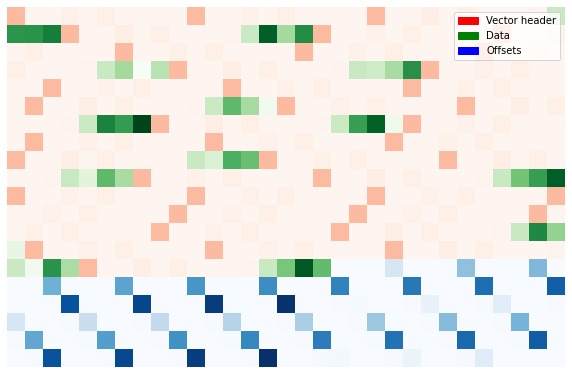

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_marked_data(data, nrows=20, ax=ax)